In [27]:
def run_on_aws(input_file, output_dir, spark_session):
    """Start of the PySpark code to run on AWS
    """

    import os
    import pyspark.sql.functions as F

    from pyspark.sql.types import StructType
    from pyspark.sql.types import StringType
    from pyspark.sql.types import DateType
    from pyspark.sql.types import IntegerType
    from pyspark.sql.types import FloatType
    from pyspark.sql.types import LongType
    from pyspark.sql.window import Window
    from pyspark.ml.feature import Bucketizer

    schema = StructType() \
            .add('CMTE_ID', StringType()) \
            .add('AMNDT_IND', StringType()) \
            .add('RPT_TP', StringType()) \
            .add('TRANSACTION_PGI', StringType()) \
            .add('IMAGE_NUM', StringType()) \
            .add('TRANSACTION_TP', StringType()) \
            .add('ENTITY_TP', StringType()) \
            .add('NAME', StringType()) \
            .add('CITY', StringType()) \
            .add('STATE', StringType()) \
            .add('ZIP_CODE', StringType()) \
            .add('EMPLOYER', StringType()) \
            .add('OCCUPATION', StringType()) \
            .add('TRANSACTION_DT', StringType()) \
            .add('TRANSACTION_AMT', FloatType()) \
            .add('OTHER_ID', StringType()) \
            .add('TRAN_ID', StringType()) \
            .add('FILE_NUM', IntegerType()) \
            .add('MEMO_CD', StringType()) \
            .add('MEMO_TEXT', StringType()) \
            .add('SUB_ID', LongType()) \
    
    campaign_ids = {'C00575795': 'HILLARY FOR AMERICA',
                    'C00577130': 'BERNIE 2016',
                    'C00580100': 'DONALD J. TRUMP FOR PRESIDENT, INC'}

    df = spark_session.read.csv(input_file, schema=schema, sep='|')
    # Convert date string to Date Type
    df = df.withColumn("TRANSACTION_DT", F.to_date(df["TRANSACTION_DT"],"mmddyyyy"))
    df = df.select("*") \
            .where(df['CMTE_ID'].isin(list(campaign_ids.keys()))) \

    # Problem 1: Number of donations for each campaign
    df.select(['CMTE_ID', 'TRANSACTION_AMT']) \
        .where(df['CMTE_ID'].isin(list(campaign_ids.keys()))) \
        .groupby(df['CMTE_ID']) \
        .count() \
        .coalesce(1) \
        .write.format('csv').save(os.path.join(output_dir, 'problem_1'))

    # Problem 2: Total amount of donations for each campaign
    df.select(['CMTE_ID', 'TRANSACTION_AMT']) \
        .where(df['CMTE_ID'].isin(list(campaign_ids.keys()))) \
        .groupby(df['CMTE_ID']) \
        .sum() \
        .coalesce(1) \
        .write.format('csv').save(os.path.join(output_dir, 'problem_2'))

    # Problem 3: Percentage of small contributors for each campaign
    df.select(['CMTE_ID', 'TRANSACTION_AMT', 'ENTITY_TP']) \
        .where(df['CMTE_ID'].isin(list(campaign_ids.keys()))) \
        .groupby(df['CMTE_ID'], df['ENTITY_TP']) \
        .sum() \
        .withColumn('percent',
                    F.col('sum(TRANSACTION_AMT)')*100/F.sum('sum(TRANSACTION_AMT)')
                        .over(Window.partitionBy())
                   ) \
        .coalesce(1) \
        .write.format('csv').save(os.path.join(output_dir, 'problem_3'))

    # Problem 4: Histogram data for each campaign
    step = 10_000
    max_val = int(df.select(F.max(df['TRANSACTION_AMT']).alias('MAX')).collect()[0].MAX)
    query = df.select(['CMTE_ID', 'TRANSACTION_AMT']) \
        .where(df['CMTE_ID'].isin(list(campaign_ids.keys()))) \
        .where(df['TRANSACTION_AMT'] > 0)
    
    schema = StructType() \
                .add("CMTE_ID", StringType()) \
                .add("TRANSACTION_AMT", FloatType()) \
                .add("buckets", FloatType())
    df_bucketed = spark.createDataFrame([], schema)

    for campaign_id in campaign_ids.keys():
        bucketizer = Bucketizer(splits=range(0, max_val+1, step), inputCol="TRANSACTION_AMT", outputCol="buckets")
        df_to_append = bucketizer.transform(query.where(query['CMTE_ID'] == campaign_id))
        df_bucketed = df_bucketed.union(df_to_append)
    
    df_bucketed.groupby(['CMTE_ID', 'buckets']) \
                .count() \
                .sort(['CMTE_ID', 'buckets']) \
                .coalesce(1) \
                .write.format('csv').save(os.path.join(output_dir, 'problem_4'))

In [28]:
run_on_aws('./data.txt', './results', spark)

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib as plt

In [42]:
problem1_df = pd.read_csv('./1.csv', header=None)
problem1_df.head()

,0,1
0,C00577130,1532260
1,C00575795,2516367
2,C00580100,134065


In [41]:
problem2_df = pd.read_csv('./2.csv', header=None)
problem2_df.head()

,0,1
0,C00577130,84399789.0
1,C00575795,293602014.0
2,C00580100,64624531.0


In [40]:
problem3_df = pd.read_csv('./3.csv', header=None)
problem3_df.head()

,0,1,2,3
0,C00577130,IND,84358086.0,19.058533
1,C00575795,COM,2500.0,0.000565
2,C00575795,PAC,10000.0,0.002259
3,C00577130,ORG,6916.0,0.001562
4,C00575795,ORG,7177.0,0.001621


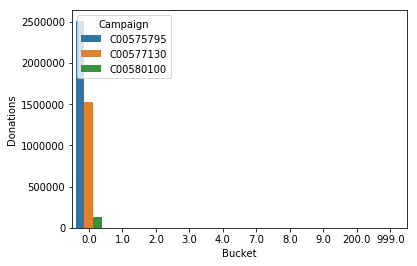

In [39]:
problem4_df = pd.read_csv('./4.csv', names=['Campaign', 'Bucket', 'Donations'])
problem4_df.head()
sns.barplot(x='Bucket', y='Donations', hue='Campaign', data=problem4_df)